In [ ]:
import yfinance as yf
from curl_cffi import requests
import matplotlib.pyplot as plt

In [ ]:
session = requests.Session(impersonate="chrome") # To fix yfinance rate limitter bug
ticker = yf.Ticker("MSFT",session=session)

In [ ]:
msft_historical_data = ticker.history(start='2000-01-01', end='2020-12-01', interval='1d').reset_index()
msft_historical_data = msft_historical_data.drop(columns=["Open","High","Low","Dividends","Stock Splits"]) # Remove unnecessary Columns

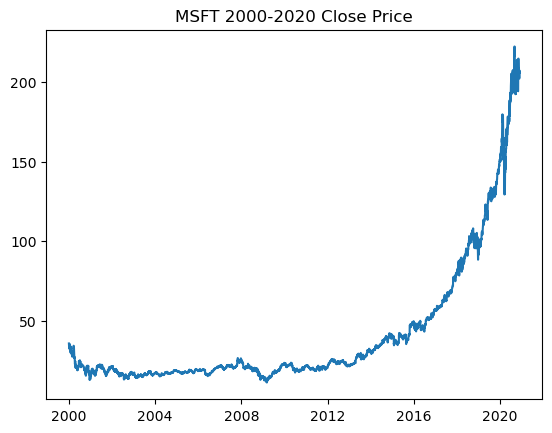

In [28]:
plt.plot(msft_historical_data["Date"],msft_historical_data["Close"])
plt.title("MSFT 2000-2020 Close Price")
plt.show()

Add SMA column

In [ ]:
msft_historical_data["SMA"] = (msft_historical_data["Close"].rolling(14).sum()) / 14

Date      2000-04-27 00:00:00-04:00
Close                     21.397722
Volume                     77669800
SMA                       23.636286
Name: 80, dtype: object